# MFA: fungal berry microbiome / climate / chemisty / plot properties


In [1]:
import pandas as pd
import numpy as np
import os
import biom
import re

# Visualizations 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from adjustText import adjust_text
from scipy.stats import zscore
import prince

%matplotlib inline

In [2]:
#!mkdir /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/MFA/berries

In [3]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/MFA/berries'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/MFA/berries


In [4]:
%env TMPDIR=/scratch/lfloerl/tmpdata

env: TMPDIR=/scratch/lfloerl/tmpdata


In [5]:
group_colors = {
    #'Bacteria': "#440154FF",        # Dark purple  
    'Climate': "#3B528BFF",         # Deep blue (adjusted for distinction)  
    'Fungi': "#21908CFF",           # Greenish teal (more distinct from Climate)  
    #'Soil': "#5DC863FF",            # Bright green  
    'Plots': "#FDE725FF",           # Bright yellow (more distinct)  
    'Chemistry': "#482677FF"        # Darker purple to distinguish from Bacteria
}


# Load data

#### Microbiome

> ITS berries: try all berries (`berries_cOTUs_rarefied_labled.tsv`) as well as only harvest ones (`berries_harvest_cOTUs_rarefied_labled.tsv`)

In [6]:
df_ITS = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/berries-closedRefOTU/berries_harvest_cOTUs_rarefied_labled.tsv', sep='\t', index_col=0)
df_ITS.index.name = "SAMPLE_NAME"

In [7]:
df_ITS.shape

(316, 777)

#### Metadata

In [8]:
md_df = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_BerryChemistry.tsv', sep='\t')
chemistry_df = md_df[['SAMPLE_NAME',  'Tartrate_gL', 'Malate_gL','Glucose_gL', 'Fructose_gL']].set_index('SAMPLE_NAME')

chemistry_df

,Tartrate_gL,Malate_gL,Glucose_gL,Fructose_gL
SAMPLE_NAME,,,,
Lavaux_2021-08-31_must_Plot4,NaN,NaN,NaN,NaN
Lavaux_2021-08-31_must_Plot5,NaN,NaN,NaN,NaN
Lavaux_2021-08-31_must_Plot9,NaN,NaN,NaN,NaN
Lavaux_2021-08-31_must_Plot11,NaN,NaN,NaN,NaN
Lavaux_2021-08-31_must_Plot12,NaN,NaN,NaN,NaN
...,...,...,...,...
Lavaux_2023-09-20_must_Plot17_RepB,1.4960,0.0970,16.3860,18.247
Lavaux_2023-09-20_must_Plot17_RepC,1.2910,0.1040,18.6630,20.781
Lavaux_2023-09-20_must_Plot17_RepD,1.1200,0.0850,17.1530,18.839


In [9]:
md_df = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv', sep='\t')
md_df = md_df[md_df['sample_type']=='must']

md_df.columns

Index(['id', 'SAMPLE_NAME', 'Fungal conc. (ng/uL)', 'Collection_ID',
       'sample_type', 'Plot_ID', 'COLLECTION_DATE', 'Replicate', 'Time_point',
       'Year', 'Year_Cat', 'Fermentation_Timepoint', 'Plot', 'Altitude',
       'Average_slope', 'Exposition', 'Min_radiation', 'Max_radiation',
       'Average_radiation', 'Soil_thickness', 'Soil_type', 'Soil_depth',
       'Hydromorphie', 'Hydromorphie_code', 'Geology', 'Coordinates',
       'Latitude', 'Longitude', 'Quadrant', 'Cluster',
       'Plot_PCA_kMeans_Cluster', 'washed'],
      dtype='object')

In [10]:
md_df = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Management.tsv', sep='\t')
md_df = md_df[md_df['sample_type']=='must']

# Plot metadata
plot_df = md_df[['SAMPLE_NAME', 'Altitude', 'Average_slope', 'Exposition','Average_radiation']].set_index('SAMPLE_NAME')
categorical_cols = ['Exposition']
plot_df_dummies = pd.get_dummies(plot_df, columns=categorical_cols, drop_first=True)
# Convert boolean columns to integers (0 or 1)
boolean_columns = plot_df_dummies.select_dtypes(include='bool').columns
plot_df_dummies[boolean_columns] = plot_df_dummies[boolean_columns].astype(int)

plot_df_dummies.tail()

,Altitude,Average_slope,Average_radiation,Exposition_South-West
SAMPLE_NAME,,,,
Lavaux_2023-09-20_must_Plot17_RepB,390,20,912.5,1
Lavaux_2023-09-20_must_Plot17_RepC,390,20,912.5,1
Lavaux_2023-09-20_must_Plot17_RepD,390,20,912.5,1
Lavaux_2023-09-20_must_Plot17_RepE,390,20,912.5,1
Lavaux_2021-09-30_must_Plot5_Row6/Vine30_ID37,400,30,912.5,1


In [11]:
md_df = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Climate.tsv', sep='\t')
md_df_soil = md_df[md_df['sample_type']=='must']

# Climate metadata
climate_df = md_df_soil[['SAMPLE_NAME', 'median_temperature', 'cv_temperature', 'median_rh', 'cv_rh' ]].set_index('SAMPLE_NAME')
#climate_df = md_df_soil[['SAMPLE_NAME', 'median_temperature',  'median_rh']].set_index('SAMPLE_NAME')


climate_df.head()

,median_temperature,cv_temperature,median_rh,cv_rh
SAMPLE_NAME,,,,
Lavaux_2021-08-31_must_Plot4,18.650958,22.587667,72.792393,16.567322
Lavaux_2021-08-31_must_Plot5,19.047366,22.104867,70.192394,16.331714
Lavaux_2021-08-31_must_Plot9,18.256629,22.831881,73.077585,16.570451
Lavaux_2021-08-31_must_Plot11,18.541438,23.246939,72.501870,16.118351
Lavaux_2021-08-31_must_Plot12,18.244984,23.615955,72.934711,16.661423


In [12]:
# make a metadata df
df_metadata = md_df_soil[['SAMPLE_NAME', 'Year', 'Plot', 'COLLECTION_DATE']].set_index('SAMPLE_NAME')

### Merge for MFA

In [13]:
# Merge all dataframes on their index
df_merged = (
    climate_df
    .join(plot_df_dummies, how="inner")
    .join(chemistry_df, how="inner")
    .join(df_ITS, how="inner")
)

# Drop rows with any NA values
df_merged.dropna(inplace=True)

# Print the shape to check the final size
print(df_merged.shape)


(301, 789)


In [14]:
df_mfa = df_merged.copy()

# Keep track of the columns' origins
Fun_columns = df_ITS.columns.tolist()
plots_columns = plot_df_dummies.columns.tolist()
climate_columns = climate_df.columns.tolist()
chemistry_columns = chemistry_df.columns.tolist()

multi_index_columns = (
    [('Climate', col) for col in climate_columns] +
    [('Plots', col) for col in plots_columns] +
    [('Chemistry', col) for col in chemistry_columns] + 
    [('Fungi', col) for col in Fun_columns])

# Subset data and assign multi-index
df_mfa.columns = pd.MultiIndex.from_tuples(multi_index_columns)  # Assign multi-index
df_mfa = df_mfa.astype("float64")

# Extract the group names (first level of multi-index)
groups = df_mfa.columns.levels[0].tolist()

df_mfa.shape

(301, 789)

In [15]:
# drop columns with zero variance 
zero_var_cols = df_mfa.std() == 0
df_mfa = df_mfa.loc[:, ~zero_var_cols]

df_mfa.shape

(301, 769)

In [16]:
# Check if there are any NaN values in df_mfa
nan_cells = df_mfa.isna().sum().sum()
print(f"Total NaN cells in df_mfa: {nan_cells}")

Total NaN cells in df_mfa: 0


### Make export file for DIABLO 

In [17]:
df_export = df_merged.merge(df_metadata, on='SAMPLE_NAME')

#df_export.reset_index(inplace=True)

md_columns = df_metadata.columns.tolist()
#md_columns.append('SAMPLE_NAME')

multi_index_columns_export = (
    [('Climate', col) for col in climate_columns] +
    [('Plots', col) for col in plots_columns] +
    [('Chemistry', col) for col in chemistry_columns] + 
    [('Fungi', col) for col in Fun_columns] + 
    [('Metadata', col) for col in md_columns])

df_export.columns = pd.MultiIndex.from_tuples(multi_index_columns_export) 

df_export.to_csv('MFA_table.csv')

# groups:
df_export.columns.levels[0]

Index(['Chemistry', 'Climate', 'Fungi', 'Metadata', 'Plots'], dtype='object')

In [18]:
df_export.head()

Climate  \
                                             median_temperature   
SAMPLE_NAME                                                       
Lavaux_2021-09-30_must_Plot4_Row6/Vine10_ID1          18.650958   
Lavaux_2021-09-30_must_Plot4_Row6/Vine30_ID2          18.650958   
Lavaux_2021-09-30_must_Plot4_Row7/Vine20_ID3          18.650958   
Lavaux_2021-09-30_must_Plot4_Row8/Vine10_ID4          18.650958   
Lavaux_2021-09-30_must_Plot4_Row8/Vine30_ID5          18.650958   

                                                                        \
                                             cv_temperature  median_rh   
SAMPLE_NAME                                                              
Lavaux_2021-09-30_must_Plot4_Row6/Vine10_ID1      22.587667  72.792393   
Lavaux_2021-09-30_must_Plot4_Row6/Vine30_ID2      22.587667  72.792393   
Lavaux_2021-09-30_must_Plot4_Row7/Vine20_ID3      22.587667  72.792393   
Lavaux_2021-09-30_must_Plot4_Row8/Vine10_ID4      22.587667  72.792393   
Lavaux_2021-09-30_must_Plot4_Row8/Vine30_ID5      22.587667  72.792393   

                                                           Plots  \
                                                  cv_rh Altitude   
SAMPLE_NAME                                                        
Lavaux_2021-09-30_must_Plot4_Row6/Vine10_ID1  16.567322      450   
Lavaux_2021-09-30_must_Plot4_Row6/Vine30_ID2  16.567322      450   
Lavaux_2021-09-30_must_Plot4_Row7/Vine20_ID3  16.567322      450   
Lavaux_2021-09-30_must_Plot4_Row8/Vine10_ID4  16.567322      450   
Lavaux_2021-09-30_must_Plot4_Row8/Vine30_ID5  16.567322      450   

                                                                              \
                                             Average_slope Average_radiation   
SAMPLE_NAME                                                                    
Lavaux_2021-09-30_must_Plot4_Row6/Vine10_ID1            30             937.5   
Lavaux_2021-09-30_must_Plot4_Row6/Vine30_ID2            30             937.5   
Lavaux_2021-09-30_must_Plot4_Row7/Vine20_ID3            30             937.5   
Lavaux_2021-09-30_must_Plot4_Row8/Vine10_ID4            30             937.5   
Lavaux_2021-09-30_must_Plot4_Row8/Vine30_ID5            30             937.5   

                                                                    \
                                             Exposition_South-West   
SAMPLE_NAME                                                          
Lavaux_2021-09-30_must_Plot4_Row6/Vine10_ID1                     1   
Lavaux_2021-09-30_must_Plot4_Row6/Vine30_ID2                     1   
Lavaux_2021-09-30_must_Plot4_Row7/Vine20_ID3                     1   
Lavaux_2021-09-30_must_Plot4_Row8/Vine10_ID4                     1   
Lavaux_2021-09-30_must_Plot4_Row8/Vine30_ID5                     1   

                                               Chemistry            ...  \
                                             Tartrate_gL Malate_gL  ...   
SAMPLE_NAME                                                         ...   
Lavaux_2021-09-30_must_Plot4_Row6/Vine10_ID1      1.2926    1.3541  ...   
Lavaux_2021-09-30_must_Plot4_Row6/Vine30_ID2      1.2926    1.3541  ...   
Lavaux_2021-09-30_must_Plot4_Row7/Vine20_ID3      1.2926    1.3541  ...   
Lavaux_2021-09-30_must_Plot4_Row8/Vine10_ID4      1.2926    1.3541  ...   
Lavaux_2021-09-30_must_Plot4_Row8/Vine30_ID5      1.2926    1.3541  ...   

                                                                                                                                           Fungi  \
                                             k__Fungi;p__Ascomycota;c__Sordariomycetes;o__Xylariales;f__Xylariaceae;g__Hypoxylon;s__unidentified   
SAMPLE_NAME                                                                                                                                        
Lavaux_2021-09-30_must_Plot4_Row6/Vine10_ID1                                                0.0                                       

#### Subset to 2021 - dense sampling 


In [19]:
df_export_2021 = df_export.loc[df_export[("Metadata", "Year")] == 2021]
df_export_2021.to_csv('MFA_2021_table.csv')

# MFA 

## How many Components?

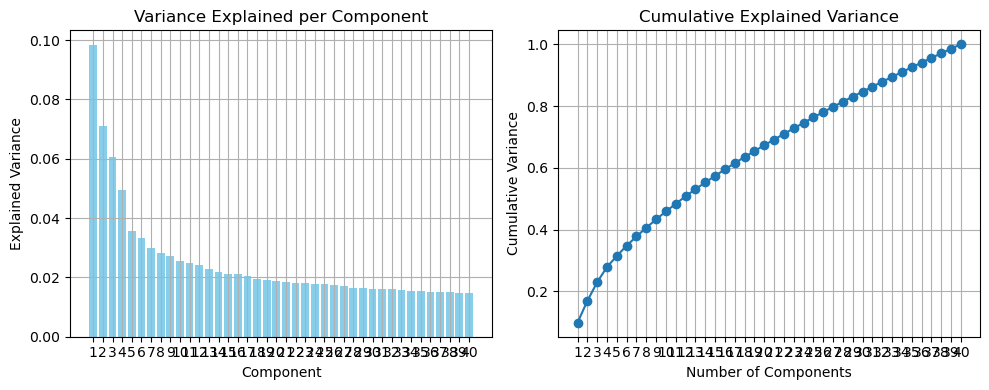

In [20]:
# Define the number of components to test
n_components = 40

# Define MFA and fit the model
mfa = prince.MFA(
    n_components=n_components,  
    n_iter=10, 
    copy=True,
    check_input=True,
    random_state=42)

# Fit MFA to the data (excluding metadata columns)
mfa = mfa.fit(
    df_mfa,
    groups=groups,
    supplementary_groups=None)

# Get explained variance per component
explained_variance_ratio = mfa.eigenvalues_ / np.sum(mfa.eigenvalues_)

# Create subplots for explained variance and cumulative variance plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Bar plot for variance explained per component
axes[0].bar(range(1, n_components + 1), explained_variance_ratio[:n_components], color='skyblue')
axes[0].set_title('Variance Explained per Component')
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Explained Variance')
axes[0].set_xticks(range(1, n_components + 1))
axes[0].grid(True)

# Line plot for cumulative explained variance (elbow plot)
axes[1].plot(range(1, n_components + 1), np.cumsum(explained_variance_ratio[:n_components]), marker='o', linestyle='-')
axes[1].set_title('Cumulative Explained Variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance')
axes[1].set_xticks(range(1, n_components + 1))
axes[1].grid(True)

# Adjust layout to ensure proper display
plt.tight_layout()
plt.show()

In [21]:
mfa.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,1.932,3.98%,3.98%
1,1.392,2.87%,6.85%
2,1.187,2.45%,9.29%
3,0.969,2.00%,11.29%
4,0.699,1.44%,12.73%
5,0.656,1.35%,14.08%
6,0.585,1.21%,15.29%
7,0.554,1.14%,16.43%
8,0.534,1.10%,17.53%


In [22]:
# Initialize MFA model
mfa = prince.MFA(
    n_components=10,  
    n_iter=10, 
    copy=True,
    check_input=True,
    random_state=42)

# Fit MFA to the data (excluding metadata columns)
mfa = mfa.fit(
    df_mfa,
    groups=groups,
    supplementary_groups=None)

mfa_results = mfa.transform(df_mfa)
# Merge MFA results with metadata to retain 'year' information
mfa_results = mfa_results.merge(df_metadata, left_index=True, right_index=True)

mfa.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,1.932,3.98%,3.98%
1,1.392,2.87%,6.85%
2,1.187,2.45%,9.29%
3,0.969,2.00%,11.29%
4,0.699,1.44%,12.73%
5,0.656,1.35%,14.08%
6,0.585,1.21%,15.29%
7,0.554,1.14%,16.43%
8,0.533,1.10%,17.53%


/scratch/lfloerl/tmpdata/ipykernel_1621956/1185779149.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Group', y='Sum of Contributions', data=df_plot, palette=group_colors)


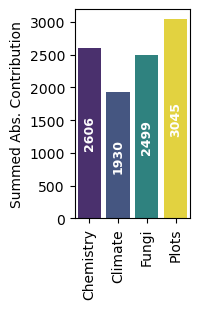

In [23]:
partial_coords = mfa.partial_row_coordinates(df_mfa)

# Assuming `partial_coords` is the dataframe you obtained from MFA
df_abs_sum = partial_coords.abs().sum()

# Convert to DataFrame for plotting
df_plot = df_abs_sum.groupby(level=0).sum().reset_index()
df_plot.columns = ['Group', 'Sum of Contributions']

# Plot
plt.figure(figsize=(2.1,3.2))
ax = sns.barplot(x='Group', y='Sum of Contributions', data=df_plot, palette=group_colors)
# Add numeric values on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2, p.get_height() * 0.5),  # Position inside the bar
                ha='center', va='center', fontsize=9, fontweight='bold', 
                color='white', rotation=90)

plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Summed Abs. Contribution')
plt.tight_layout()
plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/MFA_Berries_Contributions.png', dpi=1000)
plt.show()

# Group Contributsions

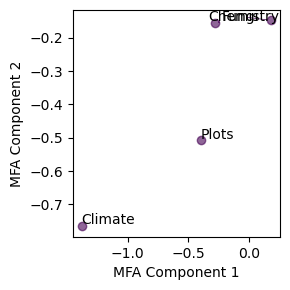

In [24]:
# get the coordinates per group 
group_rep_df =  mfa.partial_row_coordinates(df_mfa)
group_rep_df_ave = pd.DataFrame(group_rep_df.median())
group_rep_df_ave.reset_index(inplace=True)
# Rename the columns
group_rep_df_ave.columns = ['group', 'subgroup', 'value']
# Filter for only subgroups 0 and 1
group_rep_df_ave = group_rep_df_ave[group_rep_df_ave['subgroup'].isin([0, 1])]
# Pivot the DataFrame to get the desired structure
group_rep_df_ave_PC12 = group_rep_df_ave.pivot(index='group', columns='subgroup', values='value')
# Rename the columns to PC1 and PC2
group_rep_df_ave_PC12.columns = ['PC1', 'PC2']
# Reset the index to make 'group' a column
group_rep_df_ave_PC12 = group_rep_df_ave_PC12.reset_index()


# Plot
plt.figure(figsize=(3, 3))
plt.scatter(group_rep_df_ave_PC12['PC1'], group_rep_df_ave_PC12['PC2'], color='#440154FF', alpha=0.6)

# Create a list to store the text objects
texts = []

# Add labels for each group
for group_name, (x, y) in zip(group_rep_df_ave_PC12['group'], zip(group_rep_df_ave_PC12['PC1'], group_rep_df_ave_PC12['PC2'])):
    texts.append(plt.text(x, y, str(group_name), fontsize=10))

plt.xlabel("MFA Component 1")
plt.ylabel("MFA Component 2")

# Adjust the text positions to avoid overlaps and stay within the figure
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='#440154FF', lw=0.5))

plt.tight_layout()
plt.show()

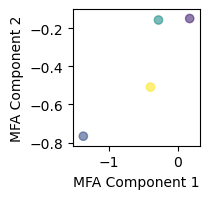

In [25]:
# Plot
# Map each group in your dataframe to its corresponding color
group_rep_df_ave_PC12['color'] = group_rep_df_ave_PC12['group'].map(group_colors)

# Plot
plt.figure(figsize=(2.2, 2.1))

# Now use the 'color' column from the dataframe to color the points
plt.scatter(group_rep_df_ave_PC12['PC1'], group_rep_df_ave_PC12['PC2'], 
            color=group_rep_df_ave_PC12['color'], alpha=0.6)

plt.xlabel("MFA Component 1")
plt.ylabel("MFA Component 2")


# Ensure all labels stay within the graph bounds by adjusting the y-axis limits
plt.ylim([group_rep_df_ave_PC12['PC2'].min() - 0.05, group_rep_df_ave_PC12['PC2'].max() + 0.05])
# Optional: Adjust x-limits if necessary to ensure full visibility of points
plt.xlim([group_rep_df_ave_PC12['PC1'].min() - 0.15, group_rep_df_ave_PC12['PC1'].max() + 0.15])

plt.tight_layout()

plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/MFA_Berries_GroupContributions.png', dpi=1000)

plt.show()


# Biplots

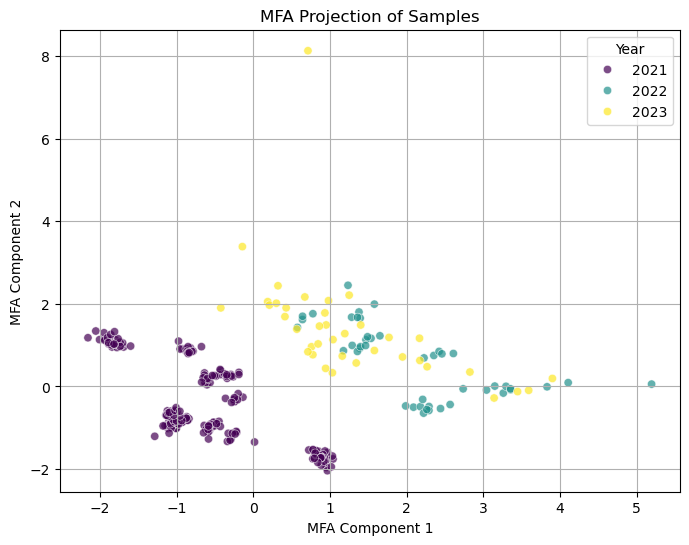

In [26]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=mfa_results, x=mfa_results.iloc[:, 0], y=mfa_results.iloc[:, 1], hue="Year", palette="viridis", alpha=0.7)
plt.xlabel("MFA Component 1")
plt.ylabel("MFA Component 2")
plt.title("MFA Projection of Samples")
plt.grid()
plt.show()

In [27]:
# Extract coordinates of individuals (first 2 components)
individuals = mfa_results.iloc[:, :2].values  

# Extract variable loadings (first 2 components) and drop multi-index properly
variable_loadings_df = mfa.column_correlations.iloc[:, :2].copy().reset_index()

# Ensure correct column names
variable_loadings_df.columns = ["Variable", "MFA Comp 1", "MFA Comp 2"]

# Compute Loadings Contribution (sum of absolute correlations)
variable_loadings_df["Loadings Contribution"] = variable_loadings_df[["MFA Comp 1", "MFA Comp 2"]].abs().sum(axis=1)

# Handle infinite values: replace with max Loadings Contribution + 0.1
max_load = variable_loadings_df.loc[np.isfinite(variable_loadings_df["Loadings Contribution"]), "Loadings Contribution"].max()
variable_loadings_df["Loadings Contribution"] = variable_loadings_df["Loadings Contribution"].replace([np.inf, -np.inf], max_load + 0.1)

# Sort by Loadings Contribution
variable_loadings_df = variable_loadings_df.sort_values(by="Loadings Contribution", ascending=False)

# Extract first character of "Variable" as "group"
variable_loadings_df["group"] = variable_loadings_df["Variable"].apply(lambda x: x[0])

# Select top 10 based on Loadings Contribution
top_loadings = variable_loadings_df.nlargest(10, "Loadings Contribution").copy()


# Extract variable names from tuples more robustly
top_loadings["Variable"] = top_loadings["Variable"].astype(str).str.extract(r",\s*([^,)]*)\)?$")[0]
# format
top_loadings['Variable'] = top_loadings['Variable'].str.replace("'", "", regex=False).str.replace("_", " ", regex=False)

tl_list = top_loadings['Variable'].to_list()

In [29]:
tl_list

['Glucose gL',
 'Fructose gL',
 'median rh',
 'Malate gL',
 'median temperature',
 'cv temperature',
 'Altitude',
 'cv rh',
 'Average slope',
 'k  Fungi;p  Ascomycota;c  Dothideomycetes;o  Pleosporales;f  unidentified;g  unidentified;s  unidentified.1']

In [30]:
# hard code the fungus 
top_loadings['Variable'] = top_loadings['Variable'].replace(
    'k  Fungi;p  Ascomycota;c  Dothideomycetes;o  Pleosporales;f  unidentified;g  unidentified;s  unidentified.1',
    "Pleosporales sp.")


In [87]:
# Function to extract the family name
def extract_family(variable):
    match = re.search(r"f__([^;]+)", variable)
    return match.group(1) if match else variable  # Return the family name if found, else keep the original value

# Apply function only to rows where 'Variable' starts with 'Bacteria_' or 'Fungi_'
#mask = top_loadings['Variable'].str.startswith(("'d__Bacteria", "'k__Fungi"))
#top_loadings.loc[mask, 'Variable'] = top_loadings.loc[mask, 'Variable'].apply(extract_family)


top_loadings

,Variable,MFA Comp 1,MFA Comp 2,Loadings Contribution,group
2,Glucose gL,-0.672597,0.614411,1.287008,Chemistry
3,Fructose gL,-0.663893,0.617324,1.281217,Chemistry
6,median rh,-0.791860,-0.460608,1.252468,Climate
1,Malate gL,-0.702010,-0.472560,1.174570,Chemistry
4,median temperature,0.428900,0.667258,1.096158,Climate
5,cv temperature,0.768188,0.310767,1.078956,Climate
765,Altitude,0.488610,-0.575182,1.063792,Plots
7,cv rh,0.792973,0.174546,0.967519,Climate
766,Average slope,0.520069,-0.121121,0.641189,Plots
30,Pleosporales sp.,0.349689,0.257343,0.607032,Fungi


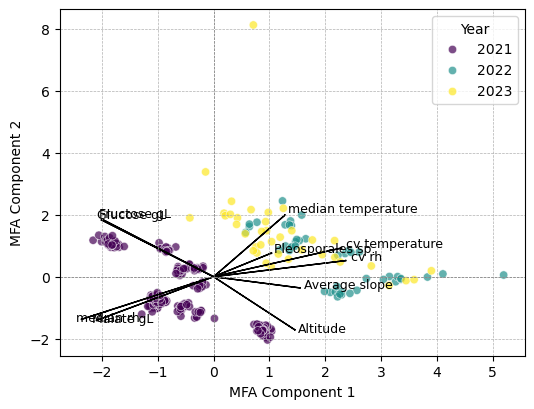

In [88]:
# Biplot
fig, ax = plt.subplots(figsize=(6, 4.5))

# Scatter plot of individuals, colored by year
sns.scatterplot(data=mfa_results, x=mfa_results.iloc[:, 0], y=mfa_results.iloc[:, 1], hue="Year", palette="viridis", alpha=0.7)


# Define a scaling factor to extend the arrows
scaling_factor = 3 # Adjust this value to control arrow length
# Plot the top loadings as arrows
for i, row in top_loadings.iterrows():
    ax.arrow(0, 0, row["MFA Comp 1"] * scaling_factor, row["MFA Comp 2"] * scaling_factor, 
             head_width=0.02, head_length=0.02, color="black", length_includes_head=True)
    
    ax.text(row["MFA Comp 1"] * (scaling_factor + 0.1),  # Adjust text position accordingly
            row["MFA Comp 2"] * (scaling_factor + 0.1), 
            row["Variable"], fontsize=9)


# Formatting
ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.set_xlabel("MFA Component 1")
ax.set_ylabel("MFA Component 2")
#ax.set_title("MFA Biplot (Samples Colored by Year)")
ax.grid(True, linestyle="--", linewidth=0.5)
ax.legend(title="Year", bbox_to_anchor=(1, 1))

plt.show()

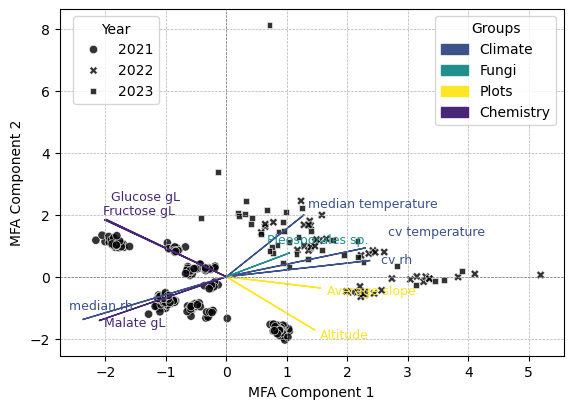

In [188]:
# Biplot
fig, ax = plt.subplots(figsize=(6.5,4.5))


# Scatter plot of individuals, colored by year
sns.scatterplot(data=mfa_results, x=mfa_results.iloc[:, 0], y=mfa_results.iloc[:, 1], style="Year", alpha=0.8, color='black')

# Define a scaling factor to extend the arrows
scaling_factor = 3  

# Create a color map based on the group and intensity (Total Contribution)
norm = plt.Normalize(vmin=top_loadings['Loadings Contribution'].min(), vmax=top_loadings['Loadings Contribution'].max())  
sm = plt.cm.ScalarMappable(cmap='Greys', norm=norm)
sm.set_array([])

## Store text objects for later adjustment
text_objects = []

for i, row in top_loadings.iterrows():
    group_color = group_colors.get(row['group'], 'black')  
    ax.arrow(0, 0, row["MFA Comp 1"] * scaling_factor, row["MFA Comp 2"] * scaling_factor, 
             head_width=0.02, head_length=0.02, color=group_color, length_includes_head=True)
    
    # Add text label with matching color
    text = ax.text(row["MFA Comp 1"] * (scaling_factor + 0.1),  
                   row["MFA Comp 2"] * (scaling_factor + 0.1), 
                   row["Variable"], fontsize=9, color=group_color)
    text_objects.append(text)

# Adjust label positions to prevent overlap
adjust_text(text_objects, ax=ax, expand_points=(1.3, 1.3), arrowprops=dict(arrowstyle="-", color='gray', lw=0))

# Add first legend for groups (custom patches)
group_legend_patches = [matplotlib.patches.Patch(color=color, label=group) for group, color in group_colors.items()]
group_legend = ax.legend(handles=group_legend_patches, title="Groups", loc="upper right", bbox_to_anchor=(0.999, 1))

# Add second legend for Year (from scatterplot)
year_legend = ax.legend(title="Year", bbox_to_anchor=(0.21, 1))

# Add both legends back to the plot
ax.add_artist(group_legend)

# Formatting
ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.set_xlabel("MFA Component 1")
ax.set_ylabel("MFA Component 2")
ax.set_title("")

# Show grid
ax.grid(True, linestyle="--", linewidth=0.5)

plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/MFA_Berries.png', dpi=1000)

plt.show()


/scratch/lfloerl/tmpdata/ipykernel_1698581/3949106651.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


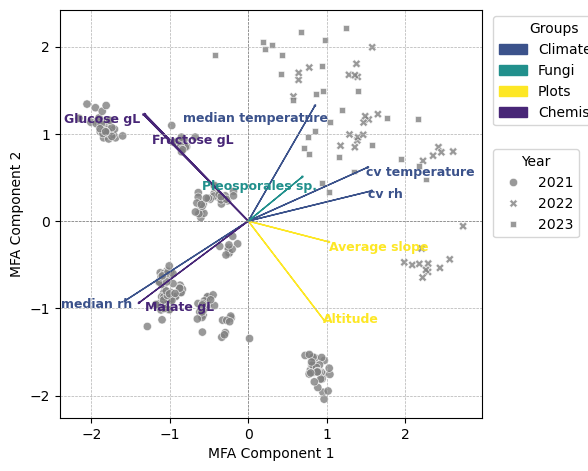

In [237]:
# Clean variable labels
top_loadings['Variable'] = top_loadings['Variable'].str.replace("'", "", regex=False)

# Filter out outliers using z-score
mfa_z = mfa_results.iloc[:, [0, 1]].apply(zscore)
threshold = 2
mask = (mfa_z.abs() < threshold).all(axis=1)
mfa_filtered = mfa_results[mask]


# Create figure
fig = plt.figure(figsize=(6.5, 4.8))  # Increase width to make space for legends
ax = fig.add_axes([0.1, 0.1, 0.65, 0.85])  # Adjust axis to fit legends

# Scatter plot of individuals, colored by year (without outliers)
sns.scatterplot(data=mfa_filtered, x=mfa_filtered.iloc[:, 0], y=mfa_filtered.iloc[:, 1], style="Year", alpha=0.8, color='grey', ax=ax)

# Scaling factor for arrows
scaling_factor = 2

# Color map for arrow intensity (Total Contribution)
norm = plt.Normalize(vmin=top_loadings['Loadings Contribution'].min(), vmax=top_loadings['Loadings Contribution'].max())
sm = plt.cm.ScalarMappable(cmap='Greys', norm=norm)
sm.set_array([])

# Store text objects
text_objects = []

# Plot arrows
for _, row in top_loadings.iterrows():
    group_color = group_colors.get(row['group'], 'black')
    ax.arrow(0, 0, row["MFA Comp 1"] * scaling_factor, row["MFA Comp 2"] * scaling_factor, head_width=0.02, head_length=0.02, color=group_color, length_includes_head=True)
    
    # Place labels before arrow tips for better readability
    text = ax.text(row["MFA Comp 1"] * (scaling_factor - 0.1), row["MFA Comp 2"] * (scaling_factor - 0.1), row["Variable"], fontsize=9, color=group_color, ha='center', va='top', fontweight='bold')
    text_objects.append(text)

# Adjust text to avoid overlap
adjust_text(text_objects, ax=ax, expand_points=(1.2, 1.2), arrowprops=dict(arrowstyle="-", color='gray', lw=0))

# Custom legend for groups
group_legend_patches = [matplotlib.patches.Patch(color=color, label=group) for group, color in group_colors.items()]
group_legend = ax.legend(handles=group_legend_patches, title="Groups", loc="center left", bbox_to_anchor=(1.01, 0.85))  # Adjust position

# Legend for year
year_legend = ax.legend(title="Year", loc="center left", bbox_to_anchor=(1.01, 0.55))  # Adjust position
ax.add_artist(group_legend)

# Formatting
ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.set_xlabel("MFA Component 1")
ax.set_ylabel("MFA Component 2")
ax.set_title("")
ax.grid(True, linestyle="--", linewidth=0.5)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/MFA_Berries_noOutliers.png', dpi=800)
plt.show()
